In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import time
import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)

In [13]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score
from sklearn.model_selection import KFold, StratifiedKFold
from lightgbm import LGBMClassifier
from scipy.stats import ranksums


In [106]:
!pip install sklearn

In [ ]:
from bayes_opt import BayesianOptimization

# EDA 

In [192]:
# set options in this notebook
pd.set_option('display.max_columns', 300)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [193]:
import os

file_path = 'Data/'
print(os.listdir(file_path))

['bureau.csv', 'POS_CASH_balance.csv', 'application_train.csv', '.ipynb_checkpoints', 'application_test.csv', 'previous_application.csv', 'installments_payments.csv', 'bureau_balance.csv', 'HomeCredit_columns_description.csv', 'credit_card_balance.csv']


In [351]:
app_train = pd.read_csv(file_path + 'application_train.csv')
app_test = pd.read_csv(file_path + 'application_test.csv')


In [352]:
app_train.tail()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
31076,136071,0,Cash loans,F,N,Y,3,117000.0,117162.0,7825.5,103500.0,Unaccompanied,State servant,Secondary / secondary special,Married,House / apartment,0.006629,-14012,-1358,-4691.0,-28,NaN,1,1,1,1,1,0,Accountants,5.0,2,2,FRIDAY,5,0,0,0,0,0,0,School,NaN,0.485830,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,0.0,4.0,0.0,-18.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
31077,136072,0,Cash loans,M,Y,Y,0,247500.0,168102.0,17964.0,148500.0,Unaccompanied,Commercial associate,Higher education,Married,House / apartment,0.019101,-18747,-1739,-6486.0,-2281,12.0,1,1,0,1,1,0,Drivers,2.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Self-employed,NaN,0.556916,0.669057,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-987.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
31078,136073,1,Cash loans,F,N,Y,0,180000.0,562491.0,27058.5,454500.0,Family,Working,Secondary / secondary special,Married,House / apartment,0.025164,-13555,-5227,-109.0,-1101,NaN,1,1,1,1,0,1,Drivers,2.0,2,2,FRIDAY,9,0,0,0,0,0,0,Business Entity Type 3,NaN,0.615644,0.411849,0.0722,0.0455,0.9821,0.7552,0.0124,0.04,0.0345,0.3333,0.375,0.0378,0.0572,0.0602,0.0077,0.1015,0.0735,0.0472,0.9821,0.7648,0.0125,0.0403,0.0345,0.3333,0.375,0.0386,0.0624,0.0627,0.0078,0.1074,0.0729,0.0455,0.9821,0.7585,0.0125,0.04,0.0345,0.3333,0.375,0.0384,0.0581,0.0613,0.0078,0.1036,reg oper account,block of flats,0.0762,"Stone, brick",No,2.0,0.0,

In [353]:
app_train.TARGET.value_counts()

0    28586
1     2495
Name: TARGET, dtype: int64

In [354]:
print(f"""percentage of clients with payment difficulties:
      {app_train.TARGET.sum() / app_train.shape[0] * 100 :.2f}%""")

percentage of clients with payment difficulties:
      8.03%


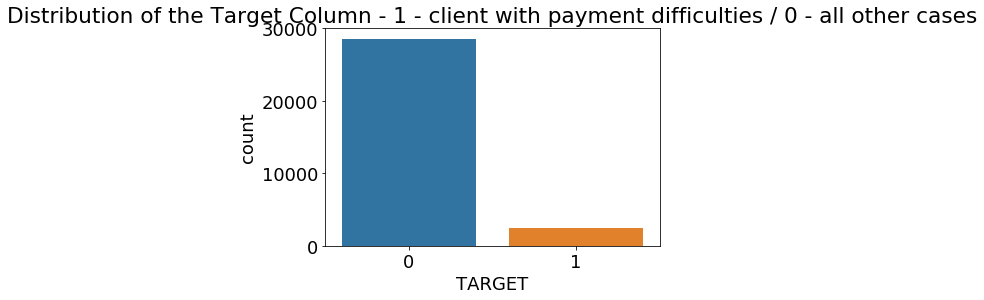

In [355]:
plt.title('Distribution of the Target Column - 1 - client with payment difficulties / 0 - all other cases')
sns.countplot(x=app_train.TARGET, data=app_train)
plt.show()

This is an <a href="http://www.chioka.in/class-imbalance-problem/" title=”Wikipedia”>class imbalance problem.</a>
There are far more repaid loans than loans that were not repaid. It is important to weight the classes by their representation in the data to reflect this imbalance.

__Column Types__

In [356]:
app_train.dtypes.value_counts()

float64    85
int64      21
object     16
dtype: int64

int64 and float64 are numeric variables which can correspond to discrete or continuous features. Whereas object columns contain strings and are categorical features.

__Missing Values__

In [357]:
# Function to calculate missing values by column# Funct // credits Will Koehrsen
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns


In [358]:
# Missing values statistics
missing_values = missing_values_table(app_train)
missing_values.head(10)

Your selected dataframe has 122 columns.
There are 85 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MODE,21801,70.1
COMMONAREA_MEDI,21801,70.1
COMMONAREA_AVG,21801,70.1
NONLIVINGAPARTMENTS_MODE,21629,69.6
NONLIVINGAPARTMENTS_MEDI,21629,69.6
NONLIVINGAPARTMENTS_AVG,21629,69.6
LIVINGAPARTMENTS_MODE,21328,68.6
LIVINGAPARTMENTS_AVG,21328,68.6
LIVINGAPARTMENTS_MEDI,21328,68.6
FONDKAPREMONT_MODE,21319,68.6


From here we have 2 options :
* Use models such as XGBoost that can handle missing values
* Or drop columns with a high percentage of missing values, and fill in other columns with a low percentag

It is not possible to know ahead of time if these columns will be helpful or not. My choice here is to drop them. Later if we need a more accurate score, we'll change the way to proceed.

__Dropping columns with a high ratio of missing values__

In [359]:

# cols_to_drop = list((app_train.isnull().sum() > 75000).index)
cols_to_drop = [c for c in app_train.columns if app_train[c].isnull().sum() > 75000]

In [360]:
app_train, app_test = app_train.drop(cols_to_drop, axis=1), app_test.drop(cols_to_drop, axis=1)
app_test.isnull().sum().sort_values(ascending=False).head(10)


COMMONAREA_MEDI             21165
COMMONAREA_AVG              21165
COMMONAREA_MODE             21165
NONLIVINGAPARTMENTS_MODE    21087
NONLIVINGAPARTMENTS_MEDI    21087
NONLIVINGAPARTMENTS_AVG     21087
FONDKAPREMONT_MODE          20743
LIVINGAPARTMENTS_AVG        20709
LIVINGAPARTMENTS_MEDI       20709
LIVINGAPARTMENTS_MODE       20709
dtype: int64

__Filling other missing values__

In [361]:
app_train.select_dtypes(include=['O']).apply(pd.Series.nunique, axis=0)


NAME_CONTRACT_TYPE             2
CODE_GENDER                    2
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               7
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             5
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

In [362]:
app_train.select_dtypes(include=['O']).apply(pd.Series.nunique, axis=0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    2
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               7
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             5
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

In [363]:
obj_cols = app_train.select_dtypes(include=['object']).columns
obj_cols

Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
       'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE',
       'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE'],
      dtype='object')

In [364]:
app_train[obj_cols] = app_train[obj_cols].fillna('Not specified')
app_test[obj_cols] = app_test[obj_cols].fillna('Not specified')

In [365]:
float_cols = app_train.select_dtypes(include=['float']).columns
float_cols

Index(['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       'REGION_POPULATION_RELATIVE', 'DAYS_REGISTRATION', 'OWN_CAR_AGE',
       'CNT_FAM_MEMBERS', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
       'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG',
       'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG',
       'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG',
       'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG',
       'NONLIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE',
       'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE', 'COMMONAREA_MODE',
       'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE',
       'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE',
       'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI',
       'BASEMENTAREA_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_MEDI',
       'COMMONAREA_MEDI', 'ELEVATORS_MEDI'

In [366]:
app_train[float_cols] = app_train[float_cols].fillna(app_train[float_cols].median())
app_test[float_cols] = app_test[float_cols].fillna(app_test[float_cols].median())

In [367]:
app_train.shape, app_test.shape

((31081, 122), (30796, 121))

__Let's check if there is still NaNs__

In [368]:
app_train.isnull().sum().sort_values(ascending=False).head()

AMT_REQ_CREDIT_BUREAU_YEAR    0
REGION_RATING_CLIENT          0
WEEKDAY_APPR_PROCESS_START    0
HOUR_APPR_PROCESS_START       0
REG_REGION_NOT_LIVE_REGION    0
dtype: int64

In [369]:
app_test.isnull().sum().sort_values(ascending=False).head()

REGION_RATING_CLIENT          1
DAYS_BIRTH                    1
REG_REGION_NOT_WORK_REGION    1
REG_REGION_NOT_LIVE_REGION    1
HOUR_APPR_PROCESS_START       1
dtype: int64

__Is there any duplicated rows ?__

In [370]:
app_train.duplicated().sum()

0

In [371]:
app_test.duplicated().sum()

0

__Categorical columns (type object)__

In [372]:
# Number of unique classes in each object column
app_train.select_dtypes(include=['object']).apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    2
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                8
NAME_INCOME_TYPE               7
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             5
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               19
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             5
HOUSETYPE_MODE                 4
WALLSMATERIAL_MODE             8
EMERGENCYSTATE_MODE            3
dtype: int64

__Dealing with anomalies__

In [373]:
app_train['DAYS_EMPLOYED'].describe()

count     31081.000000
mean      63908.694958
std      141375.632922
min      -16365.000000
25%       -2781.000000
50%       -1223.000000
75%        -286.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

*_The maximum value is abnormal (besides being positive). It corresponds to 1000 years..._*

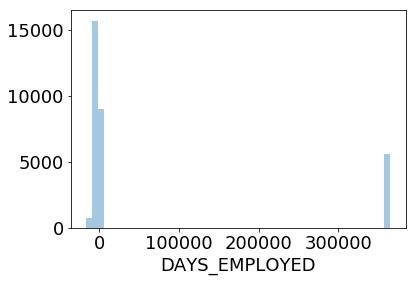

In [374]:
sns.distplot(app_train['DAYS_EMPLOYED'], kde=False);
plt.show()

In [375]:
print('The non-anomalies default on %0.2f%% of loans' % (100 * app_train[app_train['DAYS_EMPLOYED'] != 365243]['TARGET'].mean()))
print('The anomalies default on %0.2f%% of loans' % (100 * app_train[app_train['DAYS_EMPLOYED'] == 365243]['TARGET'].mean()))
print('There are %d anomalous days of employment' % len(app_train[app_train['DAYS_EMPLOYED'] == 365243]))

The non-anomalies default on 8.53% of loans
The anomalies default on 5.73% of loans
There are 5606 anomalous days of employment


It turns out that the anomalies have a lower rate of default.

The anomalous values seem to have some importance. Let's fill in the anomalous values with not a np.nan and then create a new boolean column indicating whether or not the value was anomalous.

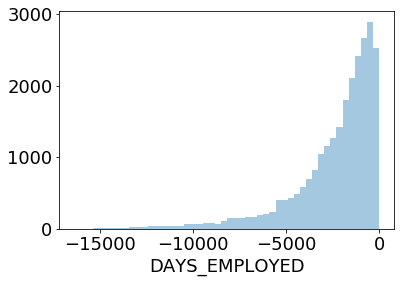

In [376]:
# Create an anomalous flag column
app_train['DAYS_EMPLOYED_ANOM'] = app_train["DAYS_EMPLOYED"] == 365243

# Replace the anomalous values with nan
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

sns.distplot(app_train['DAYS_EMPLOYED'].dropna(), kde=False);

In [377]:
app_test['DAYS_EMPLOYED_ANOM'] = app_test["DAYS_EMPLOYED"] == 365243
app_test["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)

print('There are %d anomalies in the test data out of %d entries' % (app_test["DAYS_EMPLOYED_ANOM"].sum(), len(app_test)))

There are 5826 anomalies in the test data out of 30796 entries


In [378]:
# refilling float values with median of train (not test)

app_train[float_cols] = app_train[float_cols].apply(pd.to_numeric, errors='coerce')
app_train = app_train.fillna(app_train.median())

app_test[float_cols] = app_test[float_cols].apply(pd.to_numeric, errors='coerce')
app_test = app_train.fillna(app_test.median())

# Correlations

The correlation coefficient is not the best method to represent "relevance" of a feature, but it gives us an idea of possible relationships within the data. Some general interpretations of the absolute value of the correlation coefficent are:

* 00-.19 “very weak”
* 20-.39 “weak”
* 40-.59 “moderate”
* 60-.79 “strong”
* 80-1.0 “very strong”

In [379]:
correlations = app_train.corr()['TARGET'].sort_values()

print('Most Positive Correlations:\n', correlations.tail(10))
print('\n\nMost Negative Correlations:\n', correlations.head(10))

Most Positive Correlations:
 DAYS_REGISTRATION              0.047216
DEF_60_CNT_SOCIAL_CIRCLE       0.047337
FLAG_DOCUMENT_3                0.049667
DAYS_LAST_PHONE_CHANGE         0.057809
REGION_RATING_CLIENT           0.067410
REGION_RATING_CLIENT_W_CITY    0.068180
DAYS_EMPLOYED                  0.068542
DAYS_BIRTH                     0.080539
TARGET                         1.000000
FLAG_DOCUMENT_12                    NaN
Name: TARGET, dtype: float64


Most Negative Correlations:
 EXT_SOURCE_3                 -0.160808
EXT_SOURCE_2                 -0.154529
EXT_SOURCE_1                 -0.097795
DAYS_EMPLOYED_ANOM           -0.039732
AMT_GOODS_PRICE              -0.039664
REGION_POPULATION_RELATIVE   -0.037598
FLOORSMAX_AVG                -0.034693
FLOORSMAX_MEDI               -0.034036
FLAG_PHONE                   -0.033985
FLOORSMAX_MODE               -0.033475
Name: TARGET, dtype: float64


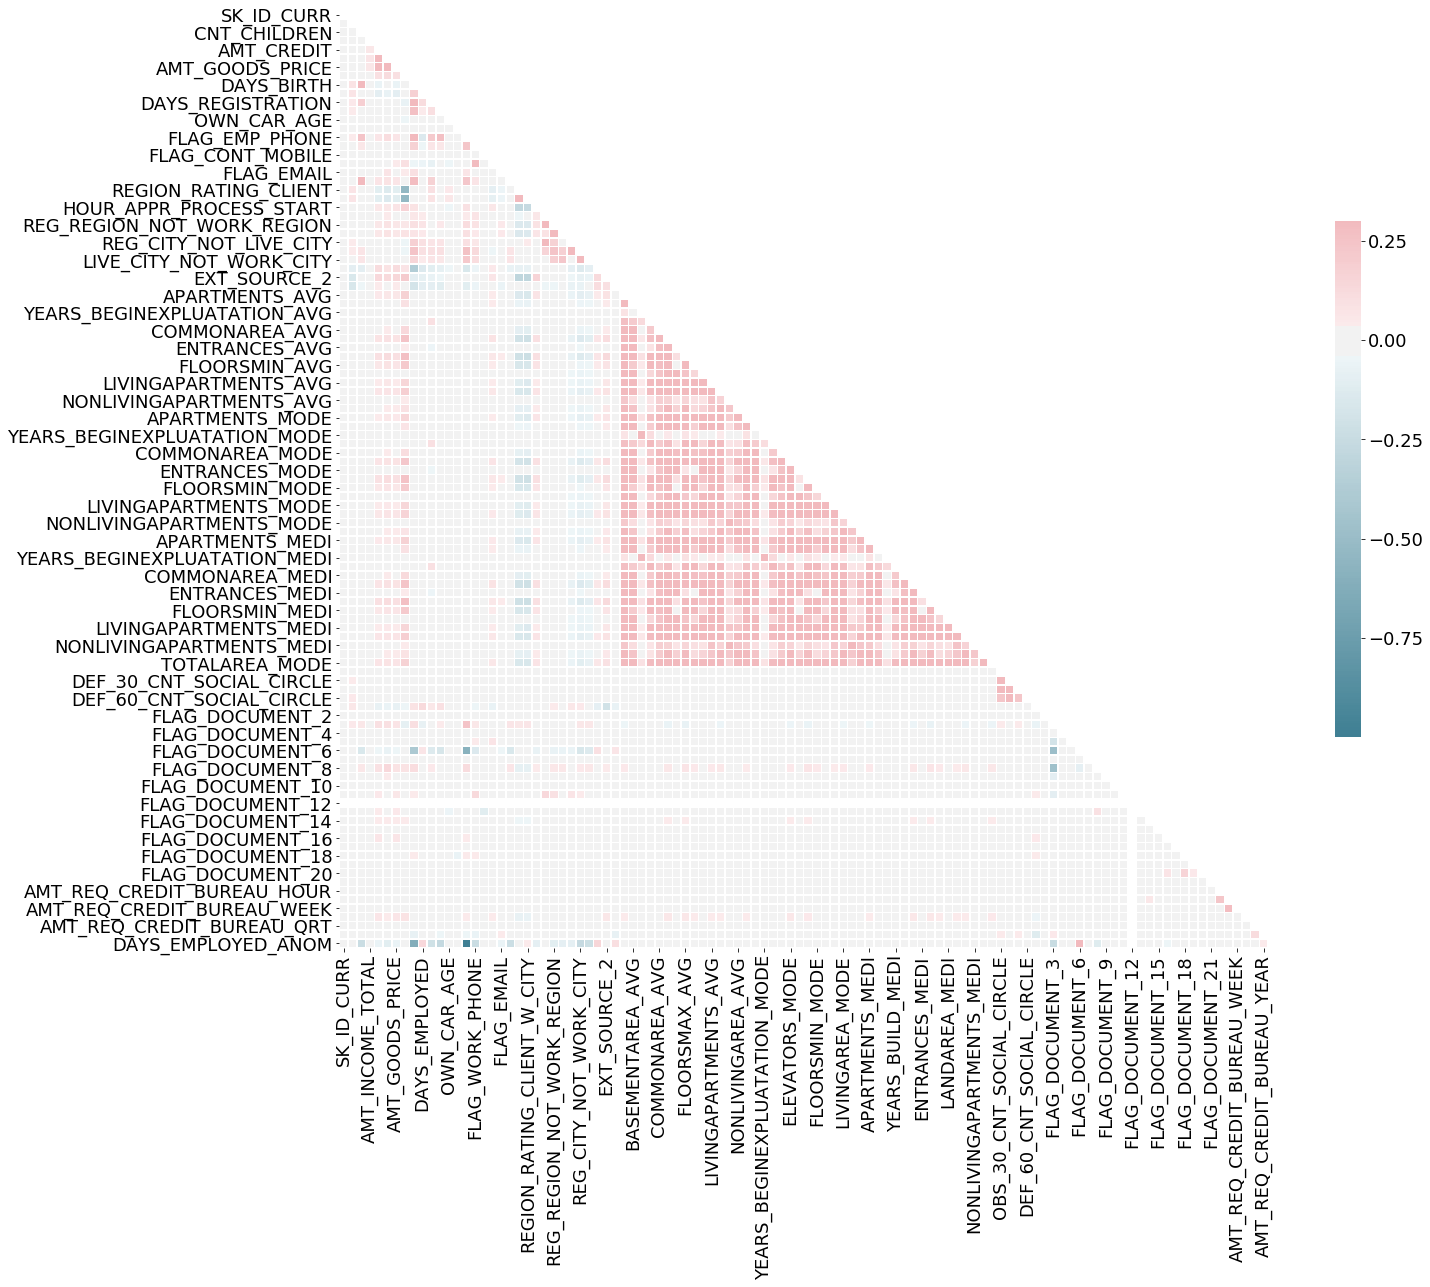

In [380]:
# Compute the correlation matrix
corr = app_train.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(21, 19))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Effect of Age on Repayment

In [381]:
# Find the correlation of the positive days since birth and target
app_train['DAYS_BIRTH'] = abs(app_train['DAYS_BIRTH'])
app_train['DAYS_BIRTH'].corr(app_train['TARGET'])

-0.08053863353504441

There isn't any correlation between age and repayment

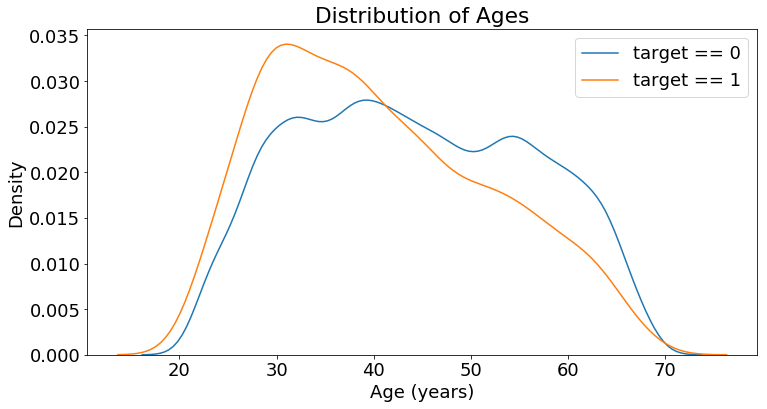

In [382]:
plt.figure(figsize = (12, 6))

# KDE plot of loans that were repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label = 'target == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label = 'target == 1')

# Labeling of plot
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages');

In [383]:
# Age information into a separate dataframe
age_data = app_train[['TARGET', 'DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365

# Bin the age data
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))
age_data.head(10)

,TARGET,DAYS_BIRTH,YEARS_BIRTH,YEARS_BINNED
0,1,9461,25.920548,"(25.0, 30.0]"
1,0,16765,45.931507,"(45.0, 50.0]"
2,0,19046,52.180822,"(50.0, 55.0]"
3,0,19005,52.068493,"(50.0, 55.0]"
4,0,19932,54.608219,"(50.0, 55.0]"
5,0,16941,46.413699,"(45.0, 50.0]"
6,0,13778,37.747945,"(35.0, 40.0]"
7,0,18850,51.643836,"(50.0, 55.0]"
8,0,20099,55.065753,"(55.0, 60.0]"
9,0,14469,39.641096,"(35.0, 40.0]"


In [384]:
# Group by the bin and calculate averages
age_groups  = age_data.groupby('YEARS_BINNED').mean()
age_groups

,TARGET,DAYS_BIRTH,YEARS_BIRTH
YEARS_BINNED,,,
"(20.0, 25.0]",0.118574,8529.540630,23.368604
"(25.0, 30.0]",0.114242,10155.551212,27.823428
"(30.0, 35.0]",0.101386,11858.517141,32.489088
"(35.0, 40.0]",0.093618,13712.698968,37.569038
"(40.0, 45.0]",0.076404,15498.075922,42.460482
"(45.0, 50.0]",0.070234,17320.187570,47.452569
"(50.0, 55.0]",0.063705,19201.134116,52.605847
"(55.0, 60.0]",0.056227,20968.919891,57.449096
"(60.0, 65.0]",0.050872,22781.690044,62.415589


In [ ]:
plt.figure(figsize = (8, 6))

# Graph the age bins and the average of the target as a bar plot
plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'])

# Plot labeling
plt.xticks(rotation = 75); plt.xlabel('Age Group (years)'); plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Age Group');

# Preparing data

__Encoding Categorical Variables__

A ML model can't deal with categorical features (except for some models such as LightGBM). One have to find a way to encode (represent) these variables as numbers. There are two main ways :

* Label encoding: assign each unique category in a categorical variable with an integer. No new columns are created. The problem with label encoding is that it gives the categories an arbitrary ordering.
* One-hot encoding: create a new column for each unique category in a categorical variable. Each observation recieves a 1 in the column for its corresponding category and a 0 in all other new columns.

In [385]:
app_train = pd.get_dummies(data=app_train, columns=obj_cols)
app_test = pd.get_dummies(data=app_test, columns=obj_cols)

__Aligning Training and Testing Data__

Both the training and testing data should have the same features (columns). One-hot encoding can more columns in the one dataset because there were some categorical variables with categories not represented in the other dataset. In order to remove the columns in the training data that are not in the testing data, one need to align the dataframes.

In [386]:
y = app_train.TARGET
app_train = app_train.drop(['TARGET'], axis = 1)


In [387]:
app_train, app_test = app_train.align(app_test, join = 'inner', axis = 1)


In [388]:
app_train.shape, app_test.shape

((31081, 249), (31081, 249))

# Scaling values

In [389]:
feat_to_scale = list(float_cols).copy()
feat_to_scale.extend(['CNT_CHILDREN', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_ID_PUBLISH', 'HOUR_APPR_PROCESS_START'])
feat_to_scale

['AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_REGISTRATION',
 'OWN_CAR_AGE',
 'CNT_FAM_MEMBERS',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_AVG',
 'YEARS_BUILD_AVG',
 'COMMONAREA_AVG',
 'ELEVATORS_AVG',
 'ENTRANCES_AVG',
 'FLOORSMAX_AVG',
 'FLOORSMIN_AVG',
 'LANDAREA_AVG',
 'LIVINGAPARTMENTS_AVG',
 'LIVINGAREA_AVG',
 'NONLIVINGAPARTMENTS_AVG',
 'NONLIVINGAREA_AVG',
 'APARTMENTS_MODE',
 'BASEMENTAREA_MODE',
 'YEARS_BEGINEXPLUATATION_MODE',
 'YEARS_BUILD_MODE',
 'COMMONAREA_MODE',
 'ELEVATORS_MODE',
 'ENTRANCES_MODE',
 'FLOORSMAX_MODE',
 'FLOORSMIN_MODE',
 'LANDAREA_MODE',
 'LIVINGAPARTMENTS_MODE',
 'LIVINGAREA_MODE',
 'NONLIVINGAPARTMENTS_MODE',
 'NONLIVINGAREA_MODE',
 'APARTMENTS_MEDI',
 'BASEMENTAREA_MEDI',
 'YEARS_BEGINEXPLUATATION_MEDI',
 'YEARS_BUILD_MEDI',
 'COMMONAREA_MEDI',
 'ELEVATORS_MEDI',
 'ENTRANCES_MEDI',
 'FLOORSMAX_MEDI',
 'FLOORSMIN_M

In [390]:

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
app_train[feat_to_scale] = scaler.fit_transform(app_train[feat_to_scale])
app_test[feat_to_scale] = scaler.fit_transform(app_test[feat_to_scale])
app_train.head()


,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,DAYS_EMPLOYED_ANOM,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,CODE_GENDER_F,CODE_GENDER_M,FLAG_OWN_CAR_N,FLAG_OWN_CAR_Y,FLAG_OWN_REALTY_N,FLAG_OWN_REALTY_Y,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Not specified,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Not specified,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Ent

__Splitting training / test datasets__

__From app_train in order to make few predictions before submission & select models__

In [391]:
from sklearn.model_selection import KFold, cross_val_score, train_test_split

X_train, X_test, y_train, y_test = train_test_split(app_train, y, test_size=0.2)

# Base line 

more infos on the <a href="https://stats.stackexchange.com/questions/132777/what-does-auc-stand-for-and-what-is-it">class Receiver Operating Characteristic Area Under the Curve (ROC AUC, also sometimes called AUROC).</a>

The Reciever Operating Characteristic (ROC) curve graphs the true positive rate versus the false positive rate:



A single line on the graph indicates the curve for a single model, and movement along a line indicates changing the threshold used for classifying a positive instance. The threshold starts at 0 in the upper right to and goes to 1 in the lower left. A curve that is to the left and above another curve indicates a better model. For example, the blue model is better than the red one (which is better than the black diagonal line which indicates a naive random guessing model).

The Area Under the Curve (AUC) is the integral of the curve. This metric is between 0 and 1 with a better model scoring higher. A model that simply guesses at random will have an ROC AUC of 0.5.

When we measure a classifier according to the ROC AUC, we do not generate 0 or 1 predictions, but rather a probability between 0 and 1.

When we get into problems with inbalanced classes, accuracy is not the best metric. A model with a high ROC AUC will also have a high accuracy, but the ROC AUC is a better representation of model performance.

__Random forrest__

In [392]:
# a simple RandomForrest Classifier without CV

from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=50)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
roc_auc_score(y_test, y_pred)

0.5

The predictions must be in the format shown in the sample_submission.csv file, where there are only two columns: __SK_ID_CURR__ and __TARGET__. Let's create a dataframe in this format from the test set and the predictions called submit.

In [393]:
def submit(model, csv_name):
    
    # fit on the whole dataset of train
    model.fit(app_train, y)
    
    # Make predictions & make sure to select the second column only
    result = model.predict_proba(app_test)[:, 1]

    submit = app_test[['SK_ID_CURR']]
    submit['TARGET'] = result

    # Save the submission to a csv file
    submit.to_csv(csv_name, index = False)

The random forrest model should score around 0.58329 when submitted which is not really good, because just above 0.5 i.e a random classifier...

__Feature Importances__

In [394]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(app_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

Feature ranking:
1. feature 29 (0.047960)
2. feature 30 (0.044273)
3. feature 10 (0.030524)
4. feature 7 (0.029572)
5. feature 0 (0.028279)
6. feature 9 (0.028070)
7. feature 4 (0.027127)
8. feature 78 (0.026968)
9. feature 8 (0.026443)
10. feature 3 (0.026388)
11. feature 6 (0.024093)
12. feature 2 (0.023483)
13. feature 5 (0.023274)
14. feature 28 (0.023255)
15. feature 21 (0.019851)
16. feature 104 (0.015785)
17. feature 76 (0.011435)
18. feature 74 (0.011428)
19. feature 11 (0.011147)
20. feature 18 (0.010942)
21. feature 56 (0.008953)
22. feature 73 (0.008691)
23. feature 70 (0.008367)
24. feature 42 (0.008030)
25. feature 1 (0.007585)
26. feature 59 (0.007286)
27. feature 33 (0.007196)
28. feature 47 (0.007181)
29. feature 31 (0.007167)
30. feature 61 (0.006980)
31. feature 45 (0.006923)
32. feature 40 (0.006870)
33. feature 32 (0.006703)
34. feature 54 (0.006674)
35. feature 68 (0.006583)
36. feature 60 (0.006498)
37. feature 46 (0.006041)
38. feature 75 (0.005992)
39. feature 6

In [395]:
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from statistics import mean,stdev,median


__Random forrest with a cross validation__

In [396]:
rf_cv = RandomForestClassifier()
scores = cross_val_score(rf_cv, X_train, y_train, cv=5, scoring='roc_auc', n_jobs=-1)
scores

array([0.62112864, 0.59822026, 0.58939809, 0.62407193, 0.60151794])

In [397]:
rf_cv.fit(X_train, y_train)
roc_auc_score(y_test, rf_cv.predict(X_test))

0.5023278945361218

# More advanced models

In [399]:
import lightgbm as lgb
lgbm = lgb.LGBMClassifier(random_state = 50)
lgbm.fit(X_train, y_train, eval_metric = 'auc')
roc_auc_score(y_train, lgbm.predict(X_train))

0.5789402202783386

In [400]:
roc_auc_score(y_test, lgbm.predict(X_test))

0.5076845772477555

Different tests on hyperparameters and results:

* underfitting / high biais -> let's try to complified the model
* max_depth = 7/11 or objective = 'binary' -> scores 0.508 / 0.508
* n_estimators=1000 -> scores 0.57 / 0.511
* class_weight = 'balanced' -> scores 0.71 / 0.68
* reg_alpha = 0.1, reg_lambda = 0.1 -> no influence

In [401]:
lgbm = lgb.LGBMClassifier(random_state = 50, n_jobs = -1, class_weight = 'balanced')
lgbm.fit(X_train, y_train, eval_metric = 'auc')
roc_auc_score(y_train, lgbm.predict(X_train))

0.8817255448469844

In [402]:
roc_auc_score(y_test, lgbm.predict(X_test))

0.6720960155570902

In [403]:
def submit_func(model, X_Test, file_name):
    model.fit(app_train, y)
    result = model.predict_proba(app_test)[:, 1]
    submit = app_test[['SK_ID_CURR']]
    submit['TARGET'] = result
    print(submit.head())
    print(submit.shape)
    submit.to_csv(file_name + '.csv', index=False)


In [404]:
submit_func(lgbm, app_test, 'lgbm_submission')

   SK_ID_CURR    TARGET
0      100002  0.866513
1      100003  0.043652
2      100004  0.161366
3      100006  0.399513
4      100007  0.446070
(31081, 2)


In [406]:
ratio = (y.shape[0] - y.sum()) / y.sum()
ratio

11.457314629258518

# LightGBM optimize

In [11]:
def reduce_mem_usage(data, verbose = True):
    start_mem = data.memory_usage().sum() / 1024**2
    if verbose:
        print('Memory usage of dataframe: {:.2f} MB'.format(start_mem))
    
    for col in data.columns:
        col_type = data[col].dtype
        
        if col_type != object:
            c_min = data[col].min()
            c_max = data[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    data[col] = data[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    data[col] = data[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    data[col] = data[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    data[col] = data[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    data[col] = data[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    data[col] = data[col].astype(np.float32)
                else:
                    data[col] = data[col].astype(np.float64)

    end_mem = data.memory_usage().sum() / 1024**2
    if verbose:
        print('Memory usage after optimization: {:.2f} MB'.format(end_mem))
        print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return data


In [14]:
def one_hot_encoder(data, nan_as_category = True):
    original_columns = list(data.columns)
    categorical_columns = [col for col in data.columns if not pd.api.types.is_numeric_dtype(data[col].dtype)]
    for c in categorical_columns:
        if nan_as_category:
            data[c].fillna('NaN', inplace = True)
        values = list(data[c].unique())
        for v in values:
            data[str(c) + '_' + str(v)] = (data[c] == v).astype(np.uint8)
    data.drop(categorical_columns, axis = 1, inplace = True)
    return data, [c for c in data.columns if c not in original_columns]


In [21]:
import os

file_path = 'Data/'
print(os.listdir(file_path))

['bureau.csv', 'POS_CASH_balance.csv', 'application_train.csv', '.ipynb_checkpoints', 'application_test.csv', 'previous_application.csv', 'installments_payments.csv', 'bureau_balance.csv', 'HomeCredit_columns_description.csv', 'credit_card_balance.csv']


In [30]:
def application_train_test(file_path = file_path, nan_as_category = True):
    # Read data and merge
    df_train = pd.read_csv(file_path + 'application_train.csv')
    df_test = pd.read_csv(file_path + 'application_test.csv')
    df = pd.concat([df_train, df_test], axis = 0, ignore_index = True)
    del df_train, df_test
    gc.collect()
    
    # Remove some rows with values not present in test set (Function pipe)
    df.drop(df[df['CODE_GENDER'] == 'XNA'].index, inplace = True)
    df.drop(df[df['NAME_INCOME_TYPE'] == 'Maternity leave'].index, inplace = True)
    df.drop(df[df['NAME_FAMILY_STATUS'] == 'Unknown'].index, inplace = True)
    
     # Remove some empty features (No eliminar)
    df.drop(['FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 
            'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 
            'FLAG_DOCUMENT_21'], axis = 1, inplace = True)
    
    # Replace some outliers
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace = True)
    df.loc[df['OWN_CAR_AGE'] > 80, 'OWN_CAR_AGE'] = np.nan
    df.loc[df['REGION_RATING_CLIENT_W_CITY'] < 0, 'REGION_RATING_CLIENT_W_CITY'] = np.nan
    df.loc[df['AMT_INCOME_TOTAL'] > 1e8, 'AMT_INCOME_TOTAL'] = np.nan
    df.loc[df['AMT_REQ_CREDIT_BUREAU_QRT'] > 10, 'AMT_REQ_CREDIT_BUREAU_QRT'] = np.nan
    df.loc[df['OBS_30_CNT_SOCIAL_CIRCLE'] > 40, 'OBS_30_CNT_SOCIAL_CIRCLE'] = np.nan

    
     # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], _ = pd.factorize(df[bin_feature])
        
        # Categorical features with One-Hot encode
    df, _ = one_hot_encoder(df, nan_as_category)
    
    # Some new features
    df['app missing'] = df.isnull().sum(axis = 1).values
    
    df['app EXT_SOURCE mean'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis = 1)
    df['app EXT_SOURCE std'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].std(axis = 1)
    df['app EXT_SOURCE prod'] = df['EXT_SOURCE_1'] * df['EXT_SOURCE_2'] * df['EXT_SOURCE_3']
    df['app EXT_SOURCE_1 * EXT_SOURCE_2'] = df['EXT_SOURCE_1'] * df['EXT_SOURCE_2']
    df['app EXT_SOURCE_1 * EXT_SOURCE_3'] = df['EXT_SOURCE_1'] * df['EXT_SOURCE_3']
    df['app EXT_SOURCE_2 * EXT_SOURCE_3'] = df['EXT_SOURCE_2'] * df['EXT_SOURCE_3']
    df['app EXT_SOURCE_1 * DAYS_EMPLOYED'] = df['EXT_SOURCE_1'] * df['DAYS_EMPLOYED']
    df['app EXT_SOURCE_2 * DAYS_EMPLOYED'] = df['EXT_SOURCE_2'] * df['DAYS_EMPLOYED']
    df['app EXT_SOURCE_3 * DAYS_EMPLOYED'] = df['EXT_SOURCE_3'] * df['DAYS_EMPLOYED']
    df['app EXT_SOURCE_1 / DAYS_BIRTH'] = df['EXT_SOURCE_1'] / df['DAYS_BIRTH']
    df['app EXT_SOURCE_2 / DAYS_BIRTH'] = df['EXT_SOURCE_2'] / df['DAYS_BIRTH']
    df['app EXT_SOURCE_3 / DAYS_BIRTH'] = df['EXT_SOURCE_3'] / df['DAYS_BIRTH']
    
    df['app AMT_CREDIT - AMT_GOODS_PRICE'] = df['AMT_CREDIT'] - df['AMT_GOODS_PRICE']
    df['app AMT_CREDIT / AMT_GOODS_PRICE'] = df['AMT_CREDIT'] / df['AMT_GOODS_PRICE']
    df['app AMT_CREDIT / AMT_ANNUITY'] = df['AMT_CREDIT'] / df['AMT_ANNUITY']
    df['app AMT_CREDIT / AMT_INCOME_TOTAL'] = df['AMT_CREDIT'] / df['AMT_INCOME_TOTAL']
    
    df['app AMT_INCOME_TOTAL / 12 - AMT_ANNUITY'] = df['AMT_INCOME_TOTAL'] / 12. - df['AMT_ANNUITY']
    df['app AMT_INCOME_TOTAL / AMT_ANNUITY'] = df['AMT_INCOME_TOTAL'] / df['AMT_ANNUITY']
    df['app AMT_INCOME_TOTAL - AMT_GOODS_PRICE'] = df['AMT_INCOME_TOTAL'] - df['AMT_GOODS_PRICE']
    df['app AMT_INCOME_TOTAL / CNT_FAM_MEMBERS'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['app AMT_INCOME_TOTAL / CNT_CHILDREN'] = df['AMT_INCOME_TOTAL'] / (1 + df['CNT_CHILDREN'])
    
    df['app most popular AMT_GOODS_PRICE'] = df['AMT_GOODS_PRICE'].isin([225000, 450000, 675000, 900000]).map({True: 1, False: 0})
    df['app popular AMT_GOODS_PRICE'] = df['AMT_GOODS_PRICE'].isin([1125000, 1350000, 1575000, 1800000, 2250000]).map({True: 1, False: 0})
    
    df['app OWN_CAR_AGE / DAYS_BIRTH'] = df['OWN_CAR_AGE'] / df['DAYS_BIRTH']
    df['app OWN_CAR_AGE / DAYS_EMPLOYED'] = df['OWN_CAR_AGE'] / df['DAYS_EMPLOYED']
    
    df['app DAYS_LAST_PHONE_CHANGE / DAYS_BIRTH'] = df['DAYS_LAST_PHONE_CHANGE'] / df['DAYS_BIRTH']
    df['app DAYS_LAST_PHONE_CHANGE / DAYS_EMPLOYED'] = df['DAYS_LAST_PHONE_CHANGE'] / df['DAYS_EMPLOYED']
    df['app DAYS_EMPLOYED - DAYS_BIRTH'] = df['DAYS_EMPLOYED'] - df['DAYS_BIRTH']
    df['app DAYS_EMPLOYED / DAYS_BIRTH'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    
    df['app CNT_CHILDREN / CNT_FAM_MEMBERS'] = df['CNT_CHILDREN'] / df['CNT_FAM_MEMBERS']
    
    return reduce_mem_usage(df)

In [42]:
def bureau_and_balance(file_path = file_path, nan_as_category = True):
    df_bureau_b = reduce_mem_usage(pd.read_csv(file_path + 'bureau_balance.csv'), verbose = False)
    
    # Some new features in bureau_balance set
    tmp = df_bureau_b[['SK_ID_BUREAU', 'STATUS']].groupby('SK_ID_BUREAU')
    tmp_last = tmp.last()
    tmp_last.columns = ['First_status']
    df_bureau_b = df_bureau_b.join(tmp_last, how = 'left', on = 'SK_ID_BUREAU')
    tmp_first = tmp.first()
    tmp_first.columns = ['Last_status']
    df_bureau_b = df_bureau_b.join(tmp_first, how = 'left', on = 'SK_ID_BUREAU')
    del tmp, tmp_first, tmp_last
    gc.collect()
    
    tmp = df_bureau_b[['SK_ID_BUREAU', 'MONTHS_BALANCE']].groupby('SK_ID_BUREAU').last()
    tmp = tmp.apply(abs)
    tmp.columns = ['Month']
    df_bureau_b = df_bureau_b.join(tmp, how = 'left', on = 'SK_ID_BUREAU')
    del tmp
    gc.collect()
    
    tmp = df_bureau_b.loc[df_bureau_b['STATUS'] == 'C', ['SK_ID_BUREAU', 'MONTHS_BALANCE']].groupby('SK_ID_BUREAU').last()
    tmp = tmp.apply(abs)
    tmp.columns = ['When_closed']
    df_bureau_b = df_bureau_b.join(tmp, how = 'left', on = 'SK_ID_BUREAU')
    del tmp
    gc.collect()
    
    df_bureau_b['Month_closed_to_end'] = df_bureau_b['Month'] - df_bureau_b['When_closed']
    
    for c in range(6):
        tmp = df_bureau_b.loc[df_bureau_b['STATUS'] == str(c), ['SK_ID_BUREAU', 'MONTHS_BALANCE']]                          .groupby('SK_ID_BUREAU').count()
        tmp.columns = ['DPD_' + str(c) + '_cnt']
        df_bureau_b = df_bureau_b.join(tmp, how = 'left', on = 'SK_ID_BUREAU')
        df_bureau_b['DPD_' + str(c) + ' / Month'] = df_bureau_b['DPD_' + str(c) + '_cnt'] / df_bureau_b['Month']
        del tmp
        gc.collect()
    df_bureau_b['Non_zero_DPD_cnt'] = df_bureau_b[['DPD_1_cnt', 'DPD_2_cnt', 'DPD_3_cnt', 'DPD_4_cnt', 'DPD_5_cnt']].sum(axis = 1)
    
    df_bureau_b, bureau_b_cat = one_hot_encoder(df_bureau_b, nan_as_category)

    # Bureau balance: Perform aggregations 
    aggregations = {}
    for col in df_bureau_b.columns:
        aggregations[col] = ['mean'] if col in bureau_b_cat else ['min', 'max', 'size']
    df_bureau_b_agg = df_bureau_b.groupby('SK_ID_BUREAU').agg(aggregations)
    df_bureau_b_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in df_bureau_b_agg.columns.tolist()])
    del df_bureau_b
    gc.collect()

    df_bureau = reduce_mem_usage(pd.read_csv(file_path + 'bureau.csv'), verbose = False)
                  
    # Replace\remove some outliers in bureau set
    df_bureau.loc[df_bureau['AMT_ANNUITY'] > .8e8, 'AMT_ANNUITY'] = np.nan
    df_bureau.loc[df_bureau['AMT_CREDIT_SUM'] > 3e8, 'AMT_CREDIT_SUM'] = np.nan
    df_bureau.loc[df_bureau['AMT_CREDIT_SUM_DEBT'] > 1e8, 'AMT_CREDIT_SUM_DEBT'] = np.nan
    df_bureau.loc[df_bureau['AMT_CREDIT_MAX_OVERDUE'] > .8e8, 'AMT_CREDIT_MAX_OVERDUE'] = np.nan
    df_bureau.loc[df_bureau['DAYS_ENDDATE_FACT'] < -10000, 'DAYS_ENDDATE_FACT'] = np.nan
    df_bureau.loc[(df_bureau['DAYS_CREDIT_UPDATE'] > 0) | (df_bureau['DAYS_CREDIT_UPDATE'] < -40000), 'DAYS_CREDIT_UPDATE'] = np.nan
    df_bureau.loc[df_bureau['DAYS_CREDIT_ENDDATE'] < -10000, 'DAYS_CREDIT_ENDDATE'] = np.nan
    
    df_bureau.drop(df_bureau[df_bureau['DAYS_ENDDATE_FACT'] < df_bureau['DAYS_CREDIT']].index, inplace = True)
    
    # Some new features in bureau set
    df_bureau['bureau AMT_CREDIT_SUM - AMT_CREDIT_SUM_DEBT'] = df_bureau['AMT_CREDIT_SUM'] - df_bureau['AMT_CREDIT_SUM_DEBT']
    df_bureau['bureau AMT_CREDIT_SUM - AMT_CREDIT_SUM_LIMIT'] = df_bureau['AMT_CREDIT_SUM'] - df_bureau['AMT_CREDIT_SUM_LIMIT']
    df_bureau['bureau AMT_CREDIT_SUM - AMT_CREDIT_SUM_OVERDUE'] = df_bureau['AMT_CREDIT_SUM'] - df_bureau['AMT_CREDIT_SUM_OVERDUE']

    df_bureau['bureau DAYS_CREDIT - CREDIT_DAY_OVERDUE'] = df_bureau['DAYS_CREDIT'] - df_bureau['CREDIT_DAY_OVERDUE']
    df_bureau['bureau DAYS_CREDIT - DAYS_CREDIT_ENDDATE'] = df_bureau['DAYS_CREDIT'] - df_bureau['DAYS_CREDIT_ENDDATE']
    df_bureau['bureau DAYS_CREDIT - DAYS_ENDDATE_FACT'] = df_bureau['DAYS_CREDIT'] - df_bureau['DAYS_ENDDATE_FACT']
    df_bureau['bureau DAYS_CREDIT_ENDDATE - DAYS_ENDDATE_FACT'] = df_bureau['DAYS_CREDIT_ENDDATE'] - df_bureau['DAYS_ENDDATE_FACT']
    df_bureau['bureau DAYS_CREDIT_UPDATE - DAYS_CREDIT_ENDDATE'] = df_bureau['DAYS_CREDIT_UPDATE'] - df_bureau['DAYS_CREDIT_ENDDATE']
    
    # Categorical features with One-Hot encode
    df_bureau, bureau_cat = one_hot_encoder(df_bureau, nan_as_category)
    
    # Bureau balance: merge with bureau.csv
    df_bureau = df_bureau.join(df_bureau_b_agg, how = 'left', on = 'SK_ID_BUREAU')
    df_bureau.drop('SK_ID_BUREAU', axis = 1, inplace = True)
    del df_bureau_b_agg
    gc.collect()
    
    # Bureau and bureau_balance aggregations for application set
    categorical = bureau_cat + bureau_b_cat
    aggregations = {}
    for col in df_bureau.columns:
        aggregations[col] = ['mean'] if col in categorical else ['min', 'max', 'size', 'mean', 'var', 'sum']
    df_bureau_agg = df_bureau.groupby('SK_ID_CURR').agg(aggregations)
    df_bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in df_bureau_agg.columns.tolist()])
    
    # Bureau: Active credits
    active_agg = df_bureau[df_bureau['CREDIT_ACTIVE_Active'] == 1].groupby('SK_ID_CURR').agg(aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    df_bureau_agg = df_bureau_agg.join(active_agg, how = 'left')
    del active_agg
    gc.collect()
    
    # Bureau: Closed credits
    closed_agg = df_bureau[df_bureau['CREDIT_ACTIVE_Closed'] == 1].groupby('SK_ID_CURR').agg(aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    df_bureau_agg = df_bureau_agg.join(closed_agg, how = 'left')
    del closed_agg, df_bureau
    gc.collect()
    
    return reduce_mem_usage(df_bureau_agg)

In [44]:
def previous_application(file_path = file_path, nan_as_category = True):
    df_prev = pd.read_csv(file_path + 'previous_application.csv')
    
    # Replace some outliers
    df_prev.loc[df_prev['AMT_CREDIT'] > 6000000, 'AMT_CREDIT'] = np.nan
    df_prev.loc[df_prev['SELLERPLACE_AREA'] > 3500000, 'SELLERPLACE_AREA'] = np.nan
    df_prev[['DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION', 
             'DAYS_LAST_DUE', 'DAYS_TERMINATION']].replace(365243, np.nan, inplace = True)
    
    # Some new features
    df_prev['prev missing'] = df_prev.isnull().sum(axis = 1).values
    df_prev['prev AMT_APPLICATION / AMT_CREDIT'] = df_prev['AMT_APPLICATION'] / df_prev['AMT_CREDIT']
    df_prev['prev AMT_APPLICATION - AMT_CREDIT'] = df_prev['AMT_APPLICATION'] - df_prev['AMT_CREDIT']
    df_prev['prev AMT_APPLICATION - AMT_GOODS_PRICE'] = df_prev['AMT_APPLICATION'] - df_prev['AMT_GOODS_PRICE']
    df_prev['prev AMT_GOODS_PRICE - AMT_CREDIT'] = df_prev['AMT_GOODS_PRICE'] - df_prev['AMT_CREDIT']
    df_prev['prev DAYS_FIRST_DRAWING - DAYS_FIRST_DUE'] = df_prev['DAYS_FIRST_DRAWING'] - df_prev['DAYS_FIRST_DUE']
    df_prev['prev DAYS_TERMINATION less -500'] = (df_prev['DAYS_TERMINATION'] < -500).astype(int)
    
    # Categorical features with One-Hot encode
    df_prev, categorical = one_hot_encoder(df_prev, nan_as_category)

    # Aggregations for application set
    aggregations = {}
    for col in df_prev.columns:
        aggregations[col] = ['mean'] if col in categorical else ['min', 'max', 'size', 'mean', 'var', 'sum']
    df_prev_agg = df_prev.groupby('SK_ID_CURR').agg(aggregations)
    df_prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in df_prev_agg.columns.tolist()])
    
    # Previous Applications: Approved Applications
    approved_agg = df_prev[df_prev['NAME_CONTRACT_STATUS_Approved'] == 1].groupby('SK_ID_CURR').agg(aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    df_prev_agg = df_prev_agg.join(approved_agg, how = 'left')
    del approved_agg
    gc.collect()
    
    # Previous Applications: Refused Applications
    refused_agg = df_prev[df_prev['NAME_CONTRACT_STATUS_Refused'] == 1].groupby('SK_ID_CURR').agg(aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    df_prev_agg = df_prev_agg.join(refused_agg, how = 'left')
    del refused_agg, df_prev
    gc.collect()
    
    return reduce_mem_usage(df_prev_agg)

In [45]:
def pos_cash(file_path = file_path, nan_as_category = True):
    df_pos = pd.read_csv(file_path + 'POS_CASH_balance.csv')
    
    # Replace some outliers
    df_pos.loc[df_pos['CNT_INSTALMENT_FUTURE'] > 60, 'CNT_INSTALMENT_FUTURE'] = np.nan
    
    # Some new features
    df_pos['pos CNT_INSTALMENT more CNT_INSTALMENT_FUTURE'] =                     (df_pos['CNT_INSTALMENT'] > df_pos['CNT_INSTALMENT_FUTURE']).astype(int)
    
    # Categorical features with One-Hot encode
    df_pos, categorical = one_hot_encoder(df_pos, nan_as_category)
    
    # Aggregations for application set
    aggregations = {}
    for col in df_pos.columns:
        aggregations[col] = ['mean'] if col in categorical else ['min', 'max', 'size', 'mean', 'var', 'sum']
    df_pos_agg = df_pos.groupby('SK_ID_CURR').agg(aggregations)
    df_pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in df_pos_agg.columns.tolist()])

    # Count POS lines
    df_pos_agg['POS_COUNT'] = df_pos.groupby('SK_ID_CURR').size()
    del df_pos
    gc.collect()
    
    return reduce_mem_usage(df_pos_agg)

In [47]:
def installments_payments(file_path = file_path, nan_as_category = True):
    df_ins = pd.read_csv(file_path + 'installments_payments.csv')
    
    # Replace some outliers
    df_ins.loc[df_ins['NUM_INSTALMENT_VERSION'] > 70, 'NUM_INSTALMENT_VERSION'] = np.nan
    df_ins.loc[df_ins['DAYS_ENTRY_PAYMENT'] < -4000, 'DAYS_ENTRY_PAYMENT'] = np.nan
    
    # Some new features
    df_ins['ins DAYS_ENTRY_PAYMENT - DAYS_INSTALMENT'] = df_ins['DAYS_ENTRY_PAYMENT'] - df_ins['DAYS_INSTALMENT']
    df_ins['ins NUM_INSTALMENT_NUMBER_100'] = (df_ins['NUM_INSTALMENT_NUMBER'] == 100).astype(int)
    df_ins['ins DAYS_INSTALMENT more NUM_INSTALMENT_NUMBER'] = (df_ins['DAYS_INSTALMENT'] > df_ins['NUM_INSTALMENT_NUMBER'] * 50 / 3 - 11500 / 3).astype(int)
    df_ins['ins AMT_INSTALMENT - AMT_PAYMENT'] = df_ins['AMT_INSTALMENT'] - df_ins['AMT_PAYMENT']
    df_ins['ins AMT_PAYMENT / AMT_INSTALMENT'] = df_ins['AMT_PAYMENT'] / df_ins['AMT_INSTALMENT']
    
    # Categorical features with One-Hot encode
    df_ins, categorical = one_hot_encoder(df_ins, nan_as_category)

    # Aggregations for application set
    aggregations = {}
    for col in df_ins.columns:
        aggregations[col] = ['mean'] if col in categorical else ['min', 'max', 'size', 'mean', 'var', 'sum']
    df_ins_agg = df_ins.groupby('SK_ID_CURR').agg(aggregations)
    df_ins_agg.columns = pd.Index(['INS_' + e[0] + "_" + e[1].upper() for e in df_ins_agg.columns.tolist()])
    
    # Count installments lines
    df_ins_agg['INSTAL_COUNT'] = df_ins.groupby('SK_ID_CURR').size()
    del df_ins
    gc.collect()
    
    return reduce_mem_usage(df_ins_agg)

In [48]:
def credit_card_balance(file_path = file_path, nan_as_category = True):
    df_card = pd.read_csv(file_path + 'credit_card_balance.csv')
    
    # Replace some outliers
    df_card.loc[df_card['AMT_PAYMENT_CURRENT'] > 4000000, 'AMT_PAYMENT_CURRENT'] = np.nan
    df_card.loc[df_card['AMT_CREDIT_LIMIT_ACTUAL'] > 1000000, 'AMT_CREDIT_LIMIT_ACTUAL'] = np.nan

    # Some new features
    df_card['card missing'] = df_card.isnull().sum(axis = 1).values
    df_card['card SK_DPD - MONTHS_BALANCE'] = df_card['SK_DPD'] - df_card['MONTHS_BALANCE']
    df_card['card SK_DPD_DEF - MONTHS_BALANCE'] = df_card['SK_DPD_DEF'] - df_card['MONTHS_BALANCE']
    df_card['card SK_DPD - SK_DPD_DEF'] = df_card['SK_DPD'] - df_card['SK_DPD_DEF']
    
    df_card['card AMT_TOTAL_RECEIVABLE - AMT_RECIVABLE'] = df_card['AMT_TOTAL_RECEIVABLE'] - df_card['AMT_RECIVABLE']
    df_card['card AMT_TOTAL_RECEIVABLE - AMT_RECEIVABLE_PRINCIPAL'] = df_card['AMT_TOTAL_RECEIVABLE'] - df_card['AMT_RECEIVABLE_PRINCIPAL']
    df_card['card AMT_RECIVABLE - AMT_RECEIVABLE_PRINCIPAL'] = df_card['AMT_RECIVABLE'] - df_card['AMT_RECEIVABLE_PRINCIPAL']

    df_card['card AMT_BALANCE - AMT_RECIVABLE'] = df_card['AMT_BALANCE'] - df_card['AMT_RECIVABLE']
    df_card['card AMT_BALANCE - AMT_RECEIVABLE_PRINCIPAL'] = df_card['AMT_BALANCE'] - df_card['AMT_RECEIVABLE_PRINCIPAL']
    df_card['card AMT_BALANCE - AMT_TOTAL_RECEIVABLE'] = df_card['AMT_BALANCE'] - df_card['AMT_TOTAL_RECEIVABLE']

    df_card['card AMT_DRAWINGS_CURRENT - AMT_DRAWINGS_ATM_CURRENT'] = df_card['AMT_DRAWINGS_CURRENT'] - df_card['AMT_DRAWINGS_ATM_CURRENT']
    df_card['card AMT_DRAWINGS_CURRENT - AMT_DRAWINGS_OTHER_CURRENT'] = df_card['AMT_DRAWINGS_CURRENT'] - df_card['AMT_DRAWINGS_OTHER_CURRENT']
    df_card['card AMT_DRAWINGS_CURRENT - AMT_DRAWINGS_POS_CURRENT'] = df_card['AMT_DRAWINGS_CURRENT'] - df_card['AMT_DRAWINGS_POS_CURRENT']
    
    # Categorical features with One-Hot encode
    df_card, categorical = one_hot_encoder(df_card, nan_as_category)
    
    # Aggregations for application set
    aggregations = {}
    for col in df_card.columns:
        aggregations[col] = ['mean'] if col in categorical else ['min', 'max', 'size', 'mean', 'var', 'sum']
    df_card_agg = df_card.groupby('SK_ID_CURR').agg(aggregations)
    df_card_agg.columns = pd.Index(['CARD_' + e[0] + "_" + e[1].upper() for e in df_card_agg.columns.tolist()])

    # Count credit card lines
    df_card_agg['CARD_COUNT'] = df_card.groupby('SK_ID_CURR').size()
    del df_card
    gc.collect()
    
    return reduce_mem_usage(df_card_agg)

In [49]:
def aggregate(file_path = file_path):
    warnings.simplefilter(action = 'ignore')
    
    print('-' * 20)
    print('1: application train & test (', time.ctime(), ')')
    print('-' * 20)
    df = application_train_test(file_path)
    print('     DF shape:', df.shape)
    
    print('-' * 20)
    print('2: bureau & balance (', time.ctime(), ')')
    print('-' * 20)
    bureau = bureau_and_balance(file_path)
    df = df.join(bureau, how = 'left', on = 'SK_ID_CURR')
    print('     DF shape:', df.shape)
    del bureau
    gc.collect()
    
    
    print('-' * 20)
    print('3: previous_application (', time.ctime(), ')')
    print('-' * 20)
    prev = previous_application(file_path)
    df = df.join(prev, how = 'left', on = 'SK_ID_CURR')
    print('     DF shape:', df.shape)
    del prev
    gc.collect()
    
    
    print('-' * 20)
    print('4: POS_CASH_balance (', time.ctime(), ')')
    print('-' * 20)
    pos = pos_cash(file_path)
    df = df.join(pos, how = 'left', on = 'SK_ID_CURR')
    print('     DF shape:', df.shape)
    del pos
    gc.collect()
    
    print('-' * 20)
    print('5: installments_payments (', time.ctime(), ')')
    print('-' * 20)
    ins = installments_payments(file_path)
    df = df.join(ins, how = 'left', on = 'SK_ID_CURR')
    print('     DF shape:', df.shape)
    del ins
    gc.collect()
    
    print('-' * 20)
    print('6: credit_card_balance (', time.ctime(), ')')
    print('-' * 20)
    cc = credit_card_balance(file_path)
    df = df.join(cc, how = 'left', on = 'SK_ID_CURR')
    print('     DF shape:', df.shape)
    del cc
    gc.collect()
    
    print('-' * 20)
    print('7: final dataset (', time.ctime(), ')')
    print('-' * 20)
    return reduce_mem_usage(df)


In [80]:
df = aggregate()

--------------------
1: application train & test ( Tue Sep 29 15:13:25 2020 )
--------------------
Memory usage of dataframe: 69.57 MB
Memory usage after optimization: 32.87 MB
Decreased by 52.8%
     DF shape: (61877, 268)
--------------------
2: bureau & balance ( Tue Sep 29 15:13:29 2020 )
--------------------
Memory usage of dataframe: 494.71 MB
Memory usage after optimization: 159.89 MB
Decreased by 67.7%
     DF shape: (61877, 2164)
--------------------
3: previous_application ( Tue Sep 29 15:14:00 2020 )
--------------------
Memory usage of dataframe: 422.43 MB
Memory usage after optimization: 146.08 MB
Decreased by 65.4%
     DF shape: (61877, 3115)
--------------------
4: POS_CASH_balance ( Tue Sep 29 15:14:13 2020 )
--------------------
Memory usage of dataframe: 116.65 MB
Memory usage after optimization: 32.18 MB
Decreased by 72.4%
     DF shape: (61877, 3172)
--------------------
5: installments_payments ( Tue Sep 29 15:14:17 2020 )
--------------------
Memory usage of data

In [81]:
# Kaggle has not ehough memory to clean this dataset
# Aggregated dataset has 3411 features

#df = aggregate()


# ## Cleaning dataset




def corr_feature_with_target(feature, target):
    c0 = feature[target == 0].dropna()
    c1 = feature[target == 1].dropna()
        
    if set(feature.unique()) == set([0, 1]):
        diff = abs(c0.mean(axis = 0) - c1.mean(axis = 0))
    else:
        diff = abs(c0.median(axis = 0) - c1.median(axis = 0))
        
    p = ranksums(c0, c1)[1] if ((len(c0) >= 20) & (len(c1) >= 20)) else 2
        
    return [diff, p]

In [82]:
def clean_data(data):
    warnings.simplefilter(action = 'ignore')
    
    # Removing empty features
    nun = data.nunique()
    empty = list(nun[nun <= 1].index)
    
    data.drop(empty, axis = 1, inplace = True)
    print('After removing empty features there are {0:d} features'.format(data.shape[1]))
    
    # Removing features with the same distribution on 0 and 1 classes
    corr = pd.DataFrame(index = ['diff', 'p'])
    ind = data[data['TARGET'].notnull()].index
    
    for c in data.columns.drop('TARGET'):
        corr[c] = corr_feature_with_target(data.loc[ind, c], data.loc[ind, 'TARGET'])

    corr = corr.T
    corr['diff_norm'] = abs(corr['diff'] / data.mean(axis = 0))
    
    to_del_1 = corr[((corr['diff'] == 0) & (corr['p'] > .05))].index
    to_del_2 = corr[((corr['diff_norm'] < .5) & (corr['p'] > .05))].drop(to_del_1).index
    to_del = list(to_del_1) + list(to_del_2)
    if 'SK_ID_CURR' in to_del:
        to_del.remove('SK_ID_CURR')
        
    data.drop(to_del, axis = 1, inplace = True)
    print('After removing features with the same distribution on 0 and 1 classes there are {0:d} features'.format(data.shape[1]))
    
    # Removing features with not the same distribution on train and test datasets
    corr_test = pd.DataFrame(index = ['diff', 'p'])
    target = data['TARGET'].notnull().astype(int)
    
    for c in data.columns.drop('TARGET'):
        corr_test[c] = corr_feature_with_target(data[c], target)

    corr_test = corr_test.T
    corr_test['diff_norm'] = abs(corr_test['diff'] / data.mean(axis = 0))
    
    bad_features = corr_test[((corr_test['p'] < .05) & (corr_test['diff_norm'] > 1))].index
    bad_features = corr.loc[bad_features][corr['diff_norm'] == 0].index
    
    data.drop(bad_features, axis = 1, inplace = True)
    print('After removing features with not the same distribution on train and test datasets there are {0:d} features'.format(data.shape[1]))
    
    del corr, corr_test
    gc.collect()
    
    # Removing features not interesting for classifier
    clf = LGBMClassifier(random_state = 0)
    train_index = data[data['TARGET'].notnull()].index
    train_columns = data.drop('TARGET', axis = 1).columns

    score = 1
    new_columns = []
    while score > .7:
        train_columns = train_columns.drop(new_columns)
        clf.fit(data.loc[train_index, train_columns], data.loc[train_index, 'TARGET'])
        f_imp = pd.Series(clf.feature_importances_, index = train_columns)
        score = roc_auc_score(data.loc[train_index, 'TARGET'], 
                              clf.predict_proba(data.loc[train_index, train_columns])[:, 1])
        new_columns = f_imp[f_imp > 0].index

    data.drop(train_columns, axis = 1, inplace = True)
    print('After removing features not interesting for classifier there are {0:d} features'.format(data.shape[1]))

    return data

In [83]:
df = clean_data(df)

After removing empty features there are 3125 features
After removing features with the same distribution on 0 and 1 classes there are 771 features
After removing features with not the same distribution on train and test datasets there are 771 features
After removing features not interesting for classifier there are 512 features


In [84]:
# Kaggle has not ehough memory to run this code - more than 14 Gb RAM

# Dataset for cleaning has 3411 features
# After removing empty features there are 3289 features
# After removing features with the same distribution on 0 and 1 classes there are 2171 features
# After removing features with not the same distribution on train and test datasets there are 2115 features
# After removing features not interesting for classifier there are 1505 features

#df = clean_data(df)


# ## Optimization LGBM parameters

# ### Optimization and visualisation functions


def cv_scores(df, num_folds, params, stratified = False, verbose = -1, 
              save_train_prediction = False, train_prediction_file_name = 'train_prediction.csv',
              save_test_prediction = True, test_prediction_file_name = 'test_prediction.csv'):
    warnings.simplefilter('ignore')
    
    clf = LGBMClassifier(**params)

    # Divide in training/validation and test data
    train_df = df[df['TARGET'].notnull()]
    test_df = df[df['TARGET'].isnull()]
    print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))

    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits = num_folds, shuffle = True, random_state = 1001)
    else:
        folds = KFold(n_splits = num_folds, shuffle = True, random_state = 1001)
        
    # Create arrays and dataframes to store results
    train_pred = np.zeros(train_df.shape[0])
    train_pred_proba = np.zeros(train_df.shape[0])

    test_pred = np.zeros(train_df.shape[0])
    test_pred_proba = np.zeros(train_df.shape[0])
    
    prediction = np.zeros(test_df.shape[0])
    
    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    
    df_feature_importance = pd.DataFrame(index = feats)
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        print('Fold', n_fold, 'started at', time.ctime())
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

        clf.fit(train_x, train_y, 
                eval_set = [(train_x, train_y), (valid_x, valid_y)], eval_metric = 'auc', 
                verbose = verbose, early_stopping_rounds = 200)

        train_pred[train_idx] = clf.predict(train_x, num_iteration = clf.best_iteration_)
        train_pred_proba[train_idx] = clf.predict_proba(train_x, num_iteration = clf.best_iteration_)[:, 1]
        test_pred[valid_idx] = clf.predict(valid_x, num_iteration = clf.best_iteration_)
        test_pred_proba[valid_idx] = clf.predict_proba(valid_x, num_iteration = clf.best_iteration_)[:, 1]
        
        prediction +=                 clf.predict_proba(test_df[feats], num_iteration = clf.best_iteration_)[:, 1] / folds.n_splits

        df_feature_importance[n_fold] = pd.Series(clf.feature_importances_, index = feats)
        
        print('Fold %2d AUC : %.6f' % (n_fold, roc_auc_score(valid_y, test_pred_proba[valid_idx])))
        del train_x, train_y, valid_x, valid_y
        gc.collect()
        
    roc_auc_train = roc_auc_score(train_df['TARGET'], train_pred_proba)
    precision_train = precision_score(train_df['TARGET'], train_pred, average = None)
    recall_train = recall_score(train_df['TARGET'], train_pred, average = None) 
    
    roc_auc_test = roc_auc_score(train_df['TARGET'], test_pred_proba)
    precision_test = precision_score(train_df['TARGET'], test_pred, average = None)
    recall_test = recall_score(train_df['TARGET'], test_pred, average = None)

    print('Full AUC score %.6f' % roc_auc_test)
    df_feature_importance.fillna(0, inplace = True)
    df_feature_importance['mean'] = df_feature_importance.mean(axis = 1)
    
    # Write prediction files
    if save_train_prediction:
        df_prediction = train_df[['SK_ID_CURR', 'TARGET']]
        df_prediction['Prediction'] = test_pred_proba
        df_prediction.to_csv(train_prediction_file_name, index = False)
        del df_prediction
        gc.collect()

    if save_test_prediction:
        df_prediction = test_df[['SK_ID_CURR']]
        df_prediction['TARGET'] = prediction
        df_prediction.to_csv(test_prediction_file_name, index = False)
        del df_prediction
        gc.collect()
    
    return df_feature_importance, [roc_auc_train, roc_auc_test,
            precision_train[0], precision_test[0], precision_train[1], precision_test[1],
            recall_train[0], recall_test[0], recall_train[1], recall_test[1], 0]


    


In [85]:
def display_folds_importances(feature_importance_df_, n_folds = 5):
    n_columns = 3
    n_rows = (n_folds + 1) // n_columns
    _, axes = plt.subplots(n_rows, n_columns, figsize=(8 * n_columns, 8 * n_rows))
    for i in range(n_folds):
        sns.barplot(x = i, y = 'index', data = feature_importance_df_.reset_index().sort_values(i, ascending = False).head(20), 
                    ax = axes[i // n_columns, i % n_columns])
    sns.barplot(x = 'mean', y = 'index', data = feature_importance_df_.reset_index().sort_values('mean', ascending = False).head(20), 
                    ax = axes[n_rows - 1, n_columns - 1])
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.show()


In [86]:
### Table for scores
scores_index = [
    'roc_auc_train', 'roc_auc_test', 
    'precision_train_0', 'precision_test_0', 
    'precision_train_1', 'precision_test_1', 
    'recall_train_0', 'recall_test_0', 
    'recall_train_1', 'recall_test_1', 
    'LB'
]

scores = pd.DataFrame(index = scores_index)

In [87]:
scores.head()

""
roc_auc_train
roc_auc_test
precision_train_0
precision_test_0
precision_train_1


In [88]:
# ### First scores with parameters from Tilii kernel


# Parameters from Tilii kernel: https://www.kaggle.com/tilii7/olivier-lightgbm-parameters-by-bayesian-opt/code
lgbm_params = {
            'nthread': 4,
            'n_estimators': 10000,
            'learning_rate': .02,
            'num_leaves': 34,
            'colsample_bytree': .9497036,
            'subsample': .8715623,
            'max_depth': 8,
            'reg_alpha': .041545473,
            'reg_lambda': .0735294,
            'min_split_gain': .0222415,
            'min_child_weight': 39.3259775,
            'silent': -1,
            'verbose': -1
}


In [89]:
feature_importance, scor = cv_scores(df, 5, lgbm_params, test_prediction_file_name = 'prediction_0.csv')


Starting LightGBM. Train shape: (31081, 512), test shape: (30796, 512)
Fold 0 started at Tue Sep 29 15:17:50 2020
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[237]	training's auc: 0.867766	training's binary_logloss: 0.212433	valid_1's auc: 0.750157	valid_1's binary_logloss: 0.241745
Fold  0 AUC : 0.750157
Fold 1 started at Tue Sep 29 15:18:04 2020
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[262]	training's auc: 0.867036	training's binary_logloss: 0.211057	valid_1's auc: 0.764314	valid_1's binary_logloss: 0.244608
Fold  1 AUC : 0.764314
Fold 2 started at Tue Sep 29 15:18:18 2020
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[338]	training's auc: 0.882565	training's binary_logloss: 0.201413	valid_1's auc: 0.74761	valid_1's binary_logloss: 0.257963
Fold  2 AUC : 0.747610
Fold 3 started at Tue Sep 29 15:18:28 2020
Training until valid

In [91]:
step = 'Tilii`s Bayesian optimization'
scores[step] = scor
scores.loc['LB', step] = .797
scores


,Tilii`s Bayesian optimization
roc_auc_train,0.871070
roc_auc_test,0.754348
precision_train_0,0.922498
precision_test_0,0.920762
precision_train_1,0.930693
precision_test_1,0.520548
recall_train_0,0.999755
recall_test_0,0.998776
recall_train_1,0.037675
recall_test_1,0.015230


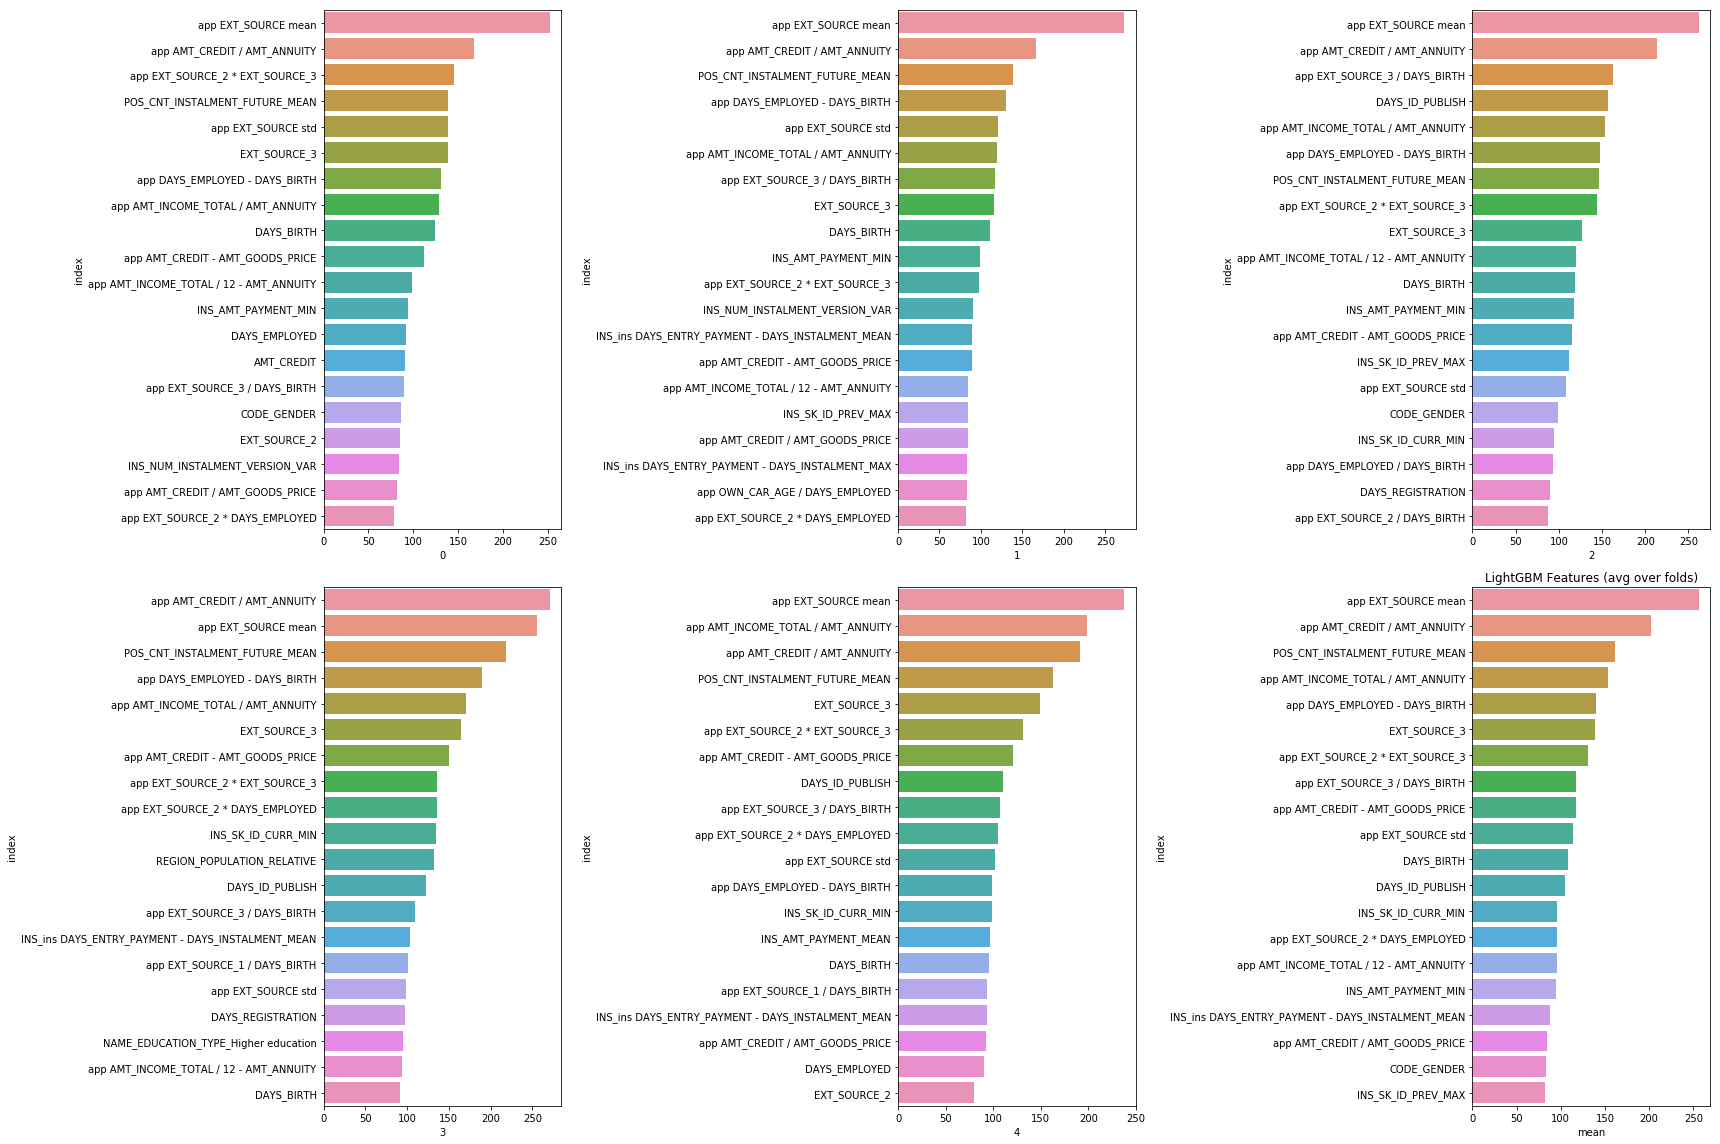

In [92]:
display_folds_importances(feature_importance)


In [93]:
feature_importance[feature_importance['mean'] == 0].shape

(177, 6)

In [94]:
feature_importance.sort_values('mean', ascending = False).head(20)

,0,1,2,3,4,mean
app EXT_SOURCE mean,252,273,262,256,238,256.2
app AMT_CREDIT / AMT_ANNUITY,167,166,214,271,191,201.8
POS_CNT_INSTALMENT_FUTURE_MEAN,139,139,146,219,163,161.2
app AMT_INCOME_TOTAL / AMT_ANNUITY,128,119,153,170,199,153.8
app DAYS_EMPLOYED - DAYS_BIRTH,131,130,148,190,99,139.6
EXT_SOURCE_3,139,116,127,164,149,139.0
app EXT_SOURCE_2 * EXT_SOURCE_3,145,98,144,136,131,130.8
app EXT_SOURCE_3 / DAYS_BIRTH,90,117,163,110,107,117.4
app AMT_CREDIT - AMT_GOODS_PRICE,112,89,115,150,121,117.4
app EXT_SOURCE std,139,120,108,99,102,113.6


__New Bayesian Optimization__

In [97]:
def lgbm_evaluate(**params):
    warnings.simplefilter('ignore')
    
    params['num_leaves'] = int(params['num_leaves'])
    params['max_depth'] = int(params['max_depth'])
        
    clf = LGBMClassifier(**params, n_estimators = 10000, nthread = 4)

    train_df = df[df['TARGET'].notnull()]
    test_df = df[df['TARGET'].isnull()]

    folds = KFold(n_splits = 2, shuffle = True, random_state = 1001)
        
    test_pred_proba = np.zeros(train_df.shape[0])
    
    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

        clf.fit(train_x, train_y, 
                eval_set = [(train_x, train_y), (valid_x, valid_y)], eval_metric = 'auc', 
                verbose = False, early_stopping_rounds = 100)

        test_pred_proba[valid_idx] = clf.predict_proba(valid_x, num_iteration = clf.best_iteration_)[:, 1]
        
        del train_x, train_y, valid_x, valid_y
        gc.collect()

    return roc_auc_score(train_df['TARGET'], test_pred_proba)




In [98]:
params = {'colsample_bytree': (0.8, 1),
          'learning_rate': (.01, .02), 
          'num_leaves': (33, 35), 
          'subsample': (0.8, 1), 
          'max_depth': (7, 9), 
          'reg_alpha': (.03, .05), 
          'reg_lambda': (.06, .08), 
          'min_split_gain': (.01, .03),
          'min_child_weight': (38, 40)}

In [154]:
from scipy.optimize import minimize

def bayesian_optimisation(design_variables):
    x = design_variables[0]
    y = design_variables[1]
    return x*(x-1)*y*(y-1)

mins = minimize(test_function, x0=(0,0), bounds=[(0,5),(0,5)])
print(mins)

      fun: 0.0
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([0., 0.])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 3
      nit: 0
   status: 0
  success: True
        x: array([0., 0.])


In [ ]:
bo = BayesianOptimization(lgbm_evaluate, params)
bo.maximize(init_points = 5, n_iter = 5)

In [ ]:


best_params = bo.res['max']['max_params']
best_params['num_leaves'] = int(best_params['num_leaves'])
best_params['max_depth'] = int(best_params['max_depth'])


In [147]:
feature_importance[feature_importance['mean'] == 0].shape

(177, 6)